✅ Normalized dataset is ready!
Found 13685 images belonging to 3 classes.
Found 3419 images belonging to 3 classes.
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 913s 9s/step - accuracy: 0.5127 - loss: 1.0437 - val_accuracy: 0.9837 - val_loss: 0.1679
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 896s 9s/step - accuracy: 0.6784 - loss: 0.6975 - val_accuracy: 0.8900 - val_loss: 0.3877
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 922s 9s/step - accuracy: 0.7075 - loss: 0.6581 - val_accuracy: 0.9375 - val_loss: 0.3131
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 918s 9s/step - accuracy: 0.7504 - loss: 0.5755 - val_accuracy: 0.9825 - val_loss: 0.1707
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 892s 9s/step - accuracy: 0.7517 - loss: 0.5631 - val_accuracy: 0.9925 - val_loss: 0.1326


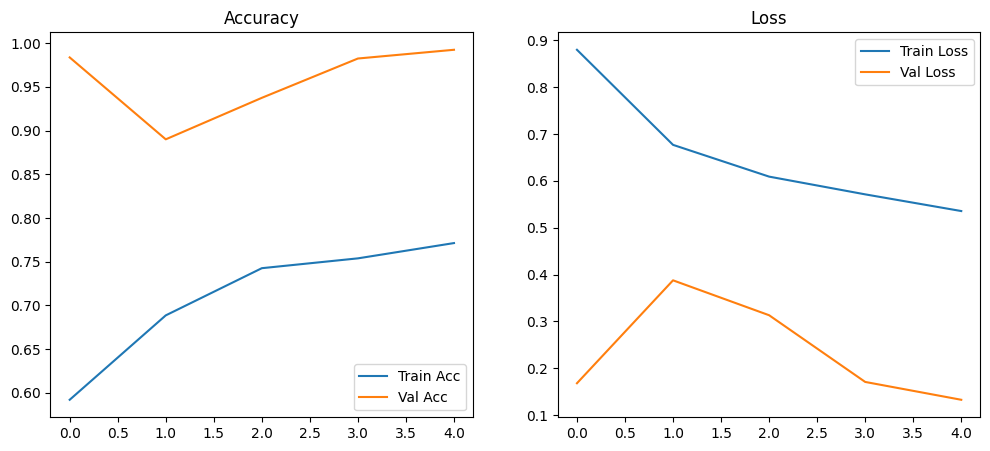

214/214 ━━━━━━━━━━━━━━━━━━━━ 1266s 6s/step
🔍 Classification Report:

              precision    recall  f1-score   support

   1NonCOVID       0.76      1.00      0.86      1378
      2COVID       0.73      0.38      0.50      1518
        3CAP       0.38      0.60      0.47       523

    accuracy                           0.66      3419
   macro avg       0.62      0.66      0.61      3419
weighted avg       0.69      0.66      0.64      3419



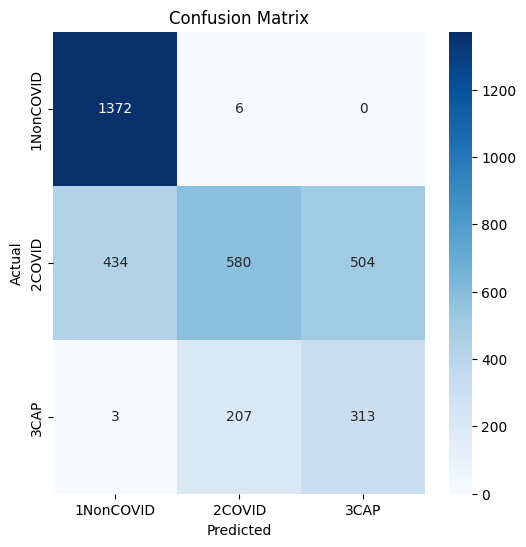

214/214 ━━━━━━━━━━━━━━━━━━━━ 1263s 6s/step - accuracy: 0.8545 - loss: 0.3618
✅ Final Accuracy: 0.6625
❌ Error Rate: 33.75%


In [ ]:
# ✅ Unzip Normalized Dataset
import zipfile
with zipfile.ZipFile("normalized_dataset_1.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/normalized_dataset")
print("✅ Normalized dataset is ready!")

# 🧪 Libraries
import tensorflow as tf
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 📁 Dataset paths
data_path = "/content/normalized_dataset/curated_data"
img_size = 160  # Reduced from 224
batch_size = 16  # Reduced for faster processing

# 🔄 Data generators
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# 🔧 VGG16 model
base_model = VGG16(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
base_model.trainable = False

x = Flatten()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax', dtype='float32')(x)  # force float32 output

model = Model(inputs=base_model.input, outputs=output)

# 🚀 Compile
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 🏋️‍♂️ Train (with limited steps for speed)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    steps_per_epoch=100,
    validation_steps=50
)

# 💾 Save model
model.save("VGG16_Optimized.h5")

# 📉 Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

# 📊 Evaluation
val_data.reset()
predictions = model.predict(val_data, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

print("🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 📌 Final Accuracy & Error
final_loss, final_acc = model.evaluate(val_data)
error_rate = (1 - final_acc) * 100
print(f"✅ Final Accuracy: {final_acc:.4f}")
print(f"❌ Error Rate: {error_rate:.2f}%")
